In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import GPy
from diGP.preprocessing_pipelines import get_SPARC_train_and_test
from diGP.model import GaussianProcessModel
from diGP.evaluation import get_SPARC_metrics

%matplotlib inline
sns.set_style('dark')

In [4]:
with open('../config.json', 'r') as json_file:
    conf = json.load(json_file)
data_paths = conf['SPARC']['data_paths']
q_test_path = conf['SPARC']['q_test_path']

Load data to use for prediction.

In [5]:
source = 'gradient_20'
gtab, data, voxel_size = get_SPARC_train_and_test(data_paths[source], data_paths['goldstandard'], q_test_path)

## GP predictions

In [6]:
gp_model = GaussianProcessModel(gtab['train'], spatial_dims=2,
                                q_magnitude_transform=None, box_cox_lambda=None)

In [7]:
gp_fit = gp_model.fit(data['train'], voxel_size=voxel_size[0:2], retrain=True)

In [8]:
mu = gp_fit.predict(gtab['test'], spatial_shape=data['test'].shape[0:2], voxel_size=voxel_size[0:2], compute_var=False)

pred = {'GP': mu}

## Reference predictions with dipy

In [9]:
import dipy.reconst.dti as dti

tenmodel = dti.TensorModel(gtab['train'])
tenfit = tenmodel.fit(data['train'])

pred['DTI'] = tenfit.predict(gtab['test'])

In [10]:
import dipy.reconst.mapmri as mapmri

map_model = mapmri.MapmriModel(gtab['train'], positivity_constraint=False, laplacian_weighting='GCV',
                               radial_order=6)
mapfit = map_model.fit(data['train'])

pred['MAP'] = mapfit.predict(gtab['test'])

## Evaluation

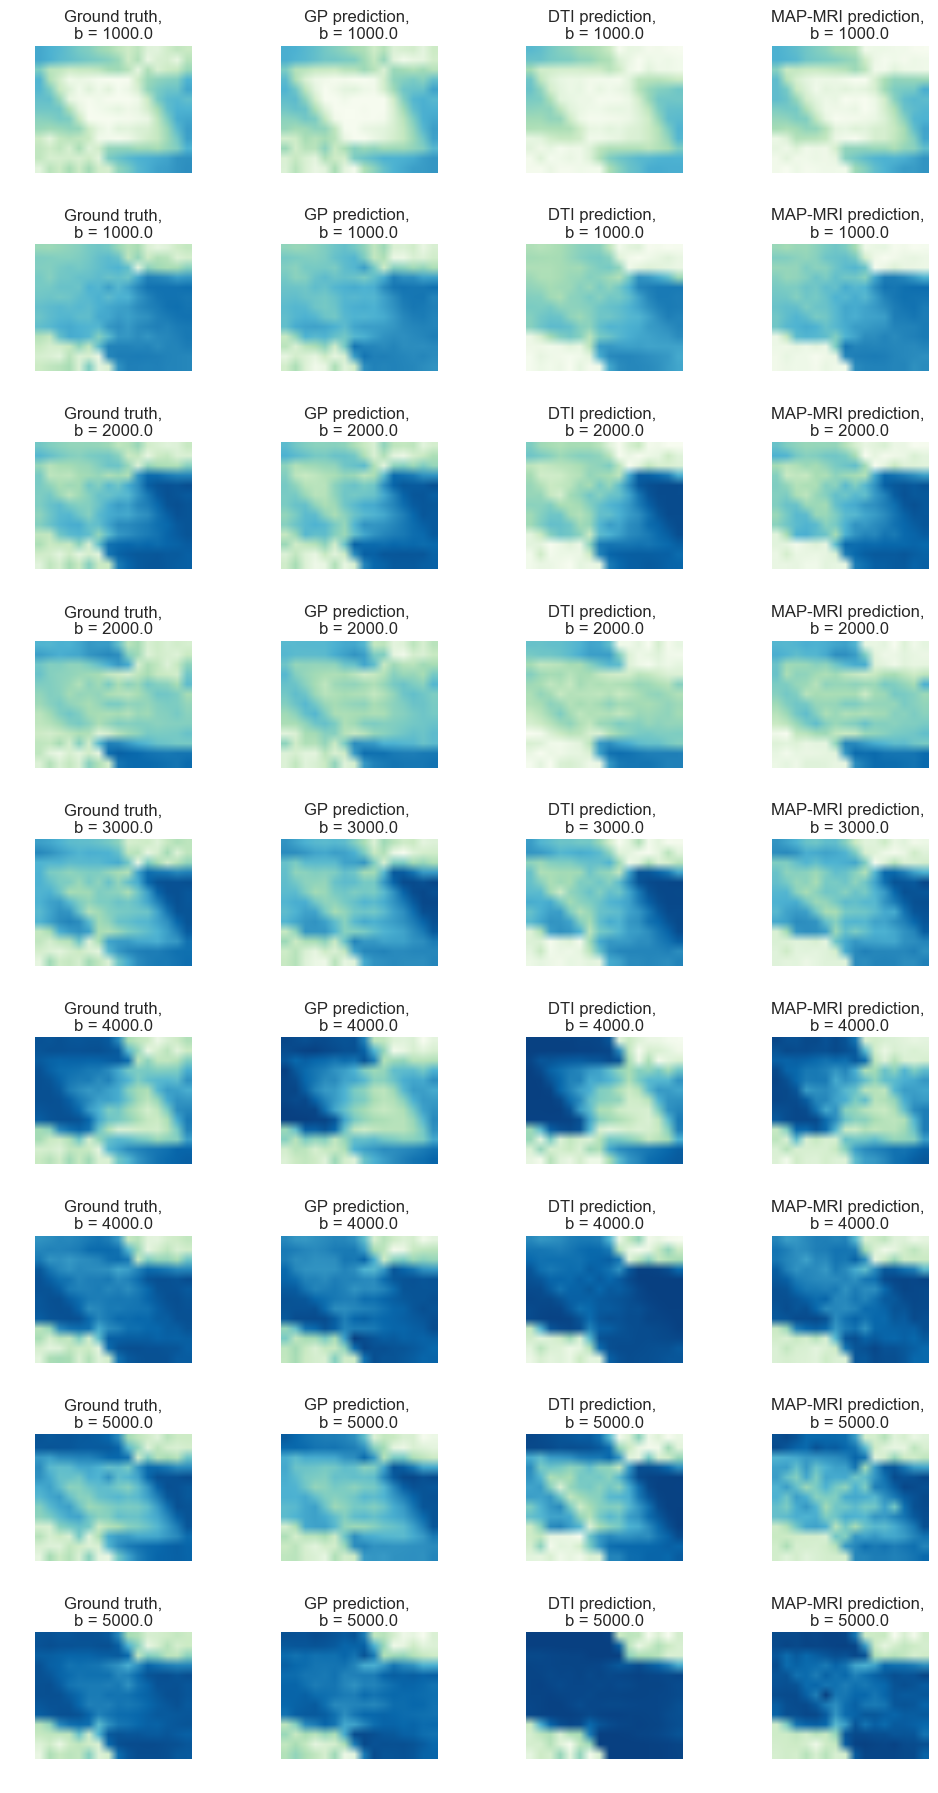

In [11]:
idx = 50 * np.arange(9)
f, axs = plt.subplots(len(idx), 4)
f.set_figheight(len(idx)*2)
f.set_figwidth(10)
for i, index in enumerate(idx):
    axs[i, 0].imshow(data['test'][:, :, index], vmin=0, vmax=1, cmap="GnBu_r")
    axs[i, 0].axis('off')
    axs[i, 0].set_title('Ground truth,\nb = {}'.format(np.round(gtab['test'].bvals[index])))
    axs[i, 1].imshow(pred['GP'][:, :, index], vmin=0, vmax=1, cmap="GnBu_r")
    axs[i, 1].axis('off')
    axs[i, 1].set_title('GP prediction, \nb = {}'.format(np.round(gtab['test'].bvals[index])))
    axs[i, 2].imshow(pred['DTI'][:, :, index], vmin=0, vmax=1, cmap="GnBu_r")
    axs[i, 2].axis('off')
    axs[i, 2].set_title('DTI prediction, \nb = {}'.format(np.round(gtab['test'].bvals[index])))
    axs[i, 3].imshow(pred['MAP'][:, :, index], vmin=0, vmax=1, cmap="GnBu_r")
    axs[i, 3].axis('off')
    axs[i, 3].set_title('MAP-MRI prediction, \nb = {}'.format(np.round(gtab['test'].bvals[index])))

plt.tight_layout()

In [12]:
for key, value in pred.items():
    print("\n{} model:".format(key))
    get_SPARC_metrics(gtab['test'], data['test'], value, verbose=True)


MAP model:
NMSE low: 0.031040994634508445
NMSE high: 0.09041411861417692
NMSE all: 0.05479024422637584

DTI model:
NMSE low: 0.07865178619130589
NMSE high: 0.24003453733688107
NMSE all: 0.14320488664953593

GP model:
NMSE low: 0.02949069882353171
NMSE high: 0.1493208595190175
NMSE all: 0.07742276310172604
